# Notebook for text generation from bulgarian sources

## The text is being generated using Recurrent Neural Network (LSTM/GRU cell)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import logging

tf.get_logger().setLevel(logging.ERROR)

In [5]:
def decode(x):
    return x.numpy().decode('utf-8')

In [106]:
TRAIN=True
DATASET=0
COLAB=True

In [107]:
if DATASET == 0:
    path_to_file = './data/dataset_vazov.txt'
elif DATASET == 1:
    path_to_file = './data/dataset_wikipedia.txt'

In [108]:
if COLAB == True:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/' + path_to_file

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [109]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [110]:
print(text[:400])

﻿	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта съвест инак днеска ми говори.
	Това расо черно, що нося отгоре,
	не ме помирява с тия небеса
	и когато в храма дигна си гласа
	химн да пея богу, да получа раят,
	мисля, че той слуша тия, що ридая


In [111]:
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
print(vocab)

153 unique characters
['\t', '\n', '\r', ' ', '!', '#', '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'V', 'X', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', 'µ', '»', 'à', 'è', 'é', 'ê', 'ò', 'ù', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'ю', 'я', 'ё', 'ґ', '—', '’', '“', '„', '…', '\ufeff']


In [112]:
example_text = ['Тогава', 'когато', 'дойде']
chars = tf.strings.unicode_split(example_text, input_encoding='UTF-8')

In [113]:
chars_to_ids = preprocessing.StringLookup(vocabulary=list(vocab))

In [114]:
complete_vocabulary=chars_to_ids.get_vocabulary()

In [115]:
ids_to_chars = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=chars_to_ids.get_vocabulary(), invert=True)

In [116]:
ids = chars_to_ids(chars)
ids

<tf.RaggedTensor [[106, 130, 119, 116, 118, 116], [126, 130, 119, 116, 134, 130], [120, 130, 125, 120, 121]]>

In [117]:
print([[decode(x) for x in y] for y in chars]) # Decoded UTF-8 characters
print(chars)

[['Т', 'о', 'г', 'а', 'в', 'а'], ['к', 'о', 'г', 'а', 'т', 'о'], ['д', 'о', 'й', 'д', 'е']]
<tf.RaggedTensor [[b'\xd0\xa2', b'\xd0\xbe', b'\xd0\xb3', b'\xd0\xb0', b'\xd0\xb2', b'\xd0\xb0'], [b'\xd0\xba', b'\xd0\xbe', b'\xd0\xb3', b'\xd0\xb0', b'\xd1\x82', b'\xd0\xbe'], [b'\xd0\xb4', b'\xd0\xbe', b'\xd0\xb9', b'\xd0\xb4', b'\xd0\xb5']]>


In [118]:
def ids_to_text(ids):
      return tf.strings.reduce_join(ids_to_chars(ids), axis=-1)

In [119]:
all_ids = chars_to_ids(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(719235,), dtype=int64, numpy=array([154,   2,  96, ...,   6,   4,   3])>

In [120]:
# Create the dataset from indexed chars
all_ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [121]:
for ids in all_ids_dataset.take(12):
    print(decode(ids_to_chars(ids)))

﻿
	
И
в
а
н
 
В
а
з
о
в


In [122]:
seq_length = 200

In [123]:
sequences = all_ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
      print(decode(tf.strings.join(ids_to_chars(seq))))

﻿	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта с


In [124]:
for seq in sequences.take(5):
    print(decode(ids_to_text(seq)))
    print('-'*80)

﻿	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта с
--------------------------------------------------------------------------------
ъвест инак днеска ми говори.
	Това расо черно, що нося отгоре,
	не ме помирява с тия небеса
	и когато в храма дигна си гласа
	химн да пея богу, да получа раят,
	мисля, че той слуша тия, що ридаят
--------------------------------------------------------------------------------

	в тоя дол плачевни, живот нестърпим.
	И мойта молитва се губи кат дим,
	и господ сърдит си затуля ухото
	на светата песен и херувикото*.
	[* Църковна песен.]

	Мисля, че вратата на небесний рай
--------------------------------------------------------------------------------

	на къде изглеждат никой ги не знай,
	че не таз килия извожда нататък,
	че из света шумен пътят е по-кратък,
	че сълзите чисти, че вдовишкий плач,
	че потът почтенний на п

In [125]:
def generate_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [126]:
print(generate_target(list("test123")))

(['t', 'e', 's', 't', '1', '2'], ['e', 's', 't', '1', '2', '3'])


In [127]:
dataset = sequences.map(generate_target)

In [128]:
for input_txt, target_txt in  dataset.take(1):
    print("Input text:\n", decode(ids_to_text(input_txt)))
    print("Target text:\n", decode(ids_to_text(target_txt)))

for i, (input_idx, target_idx) in enumerate(zip(input_txt[:6], target_txt[:6])):
    print('Step #{}'.format(i))
    print('Input: {} ({})'.format(input_idx, decode(ids_to_chars(input_idx))))
    print('Target output: {} ({})'.format(target_idx, decode(ids_to_chars(target_idx))))
    print()

Input text:
 ﻿	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта 
Target text:
 	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта с
Step #0
Input: 154 (﻿)
Target output: 2 (	)

Step #1
Input: 2 (	)
Target output: 96 (И)

Step #2
Input: 96 (И)
Target output: 118 (в)

Step #3
Input: 118 (в)
Target output: 116 (а)

Step #4
Input: 116 (а)
Target output: 129 (н)

Step #5
Input: 129 (н)
Target output: 5 ( )



In [129]:
for input_txt, target_txt in  dataset.take(1):
    print("Input text:\n", decode(ids_to_text(input_txt)))
    print("Target text:\n", decode(ids_to_text(target_txt)))

Input text:
 ﻿	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта 
Target text:
 	Иван Вазов
	Епопея на забравените

	Левски

	Манастирът тесен за мойта душа е.
	Кога човек дойде тук да се покае,
	трябва да забрави греховния мир,
	да бяга съблазни и да търси мир.
	Мойта с


In [130]:
BATCH_SIZE = 64
BUFFER_SIZE = 300
PREFETCH_SIZE = 10

dataset_train = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(PREFETCH_SIZE))

dataset_train

<PrefetchDataset shapes: ((64, 200), (64, 200)), types: (tf.int64, tf.int64)>

In [131]:
# Use first 5 batches for testing
# More can be used depending on the dataset
dataset_test = dataset_train.take(5)
dataset_train = dataset_train.skip(5)

dataset_test

<TakeDataset shapes: ((64, 200), (64, 200)), types: (tf.int64, tf.int64)>

In [132]:
# Length of the vocabulary in chars
vocabulary_size = len(complete_vocabulary)

# The embedding dimension
embedding_dimension = 256

# Number of RNN units
rnn_units = 1024

In [133]:
class RNNModel(tf.keras.Model):
    def __init__(self, vocabulary_size, embedding_dimension, rnn_units, name=None):
        super().__init__(self)
        self.vocabulary_size = vocabulary_size
        self.embedding_dimension = embedding_dimension
        self.rnn_units = rnn_units

        self.embedding = tf.keras.layers.Embedding(vocabulary_size, 
                                                   embedding_dimension, batch_input_shape=[BATCH_SIZE, None])
        self.gru = tf.keras.layers.GRU(rnn_units, 
                                       return_sequences=True, return_state=True)
        
        self.dense = tf.keras.layers.Dense(vocabulary_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else: 
            return x

    def build_graph(self):
        graph = tf.keras.models.Sequential()

        graph.add(self.embedding)

        graph.add(tf.keras.layers.GRU(
          units=self.rnn_units,
          return_sequences=True,
          stateful=True,
          recurrent_initializer=tf.keras.initializers.GlorotNormal()
        ))

        graph.add(self.dense)
      
        return graph

In [134]:
model = RNNModel(
    vocabulary_size=len(chars_to_ids.get_vocabulary()),
    embedding_dimension=embedding_dimension,
    rnn_units=rnn_units)

In [135]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(input_example_batch.shape, "(batch_size, sequence_length)")
    print(example_batch_predictions.shape, "(batch_size, sequence_length, vocab_size)")

(64, 200) (batch_size, sequence_length)
(64, 200, 155) (batch_size, sequence_length, vocab_size)


In [136]:
model.summary()

Model: "rnn_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  39680     
_________________________________________________________________
gru_4 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_2 (Dense)              multiple                  158875    
Total params: 4,136,859
Trainable params: 4,136,859
Non-trainable params: 0
_________________________________________________________________


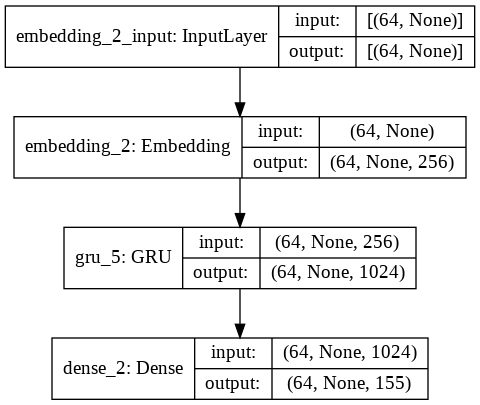

In [137]:
tf.keras.utils.plot_model(
    model.build_graph(),
    show_shapes=True,
    show_layer_names=True,
)

In [138]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
len(sampled_indices)

200

In [139]:
sampled_indices

array([107,   1, 146,  51,  92,  20,  11,  42,  23, 128,  48, 121,  44,
       107, 130,   9,  10,  15,  34, 130,  36,   5,  98, 134,  57,  39,
       140,  62, 119,  10, 106,  50,  20, 101,   3, 129,  10,  76,  59,
        97, 121, 142,  24,  53,  46,  95,  17,  48, 120, 123,  21,  79,
       140, 150,  27,  16,  83,  23,  70,  77, 137, 114,  91,  30,  50,
        48, 130,  89,  89,  59,   2,  65,  31, 111,  87,   2,  18,  30,
        80,  59, 134, 111,  60, 113,  83, 116,  94,  71,  92, 119,  83,
        91, 108,  30, 139,  67, 130,  61,  52, 136, 115,  53,  97, 148,
       121,  31,  55, 124, 153,  72,  53,  37,  73,  20, 111, 120,  79,
       144, 131,  11,  24,  83, 110, 109,  66, 148, 104, 140,  42, 141,
        96,   2,  97, 104, 125, 115, 115,  92,  78,   7,  93,  79,  60,
       110,  72,   3, 111,  60,  41,  74,  42,  84,  48,  54,  51,  77,
       104, 140,  75,  95,  41,  26, 105,  19,  69,  55, 118, 107, 153,
        50,  55, 113,  27, 137, 120,  32, 130,  65, 135,  33,  3

In [140]:
print("Input:\n", decode(ids_to_text(input_example_batch[0])))
print()
print("Predictions:\n", decode(ids_to_text(sampled_indices)))

Input:
 мен
	нищо ми не вричат
	и декември с май засмен
	в нищо не отличат.

	Скоро ще се разшумят
	долини, горички
	и цветя ще се явят
	ведно с лястовички.

	Ведро небе ще синей
	над златното слън

Predictions:
 У[UNK]я_Д6,P9мXеRУо)*1GоI КтeMшjг*Т]6Н
н*xgЙеъ:aTЗ3Xдз7«ш’?2è9ryхЮГC]XоББg	mDЧù	4CµgтЧhЩèаЖsДгèГФCчoоi`фЯaЙґеDcи…taJu6Чд«ьп,:èЦХnґРшPщИ	ЙРйЯЯДz#Е«hЦt
ЧhOvPéXb_yРшwЗO>С5qcвУ…]cЩ?хдEоmуFCґЗТo«ф. хюмJб0sюu>ч


In [141]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [142]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 200, 155)  # (batch_size, sequence_length, vocab_size)
Mean loss:         5.0441785


In [143]:
tf.exp(mean_loss).numpy()

155.1168

In [144]:
model.compile(optimizer='adam', loss=loss, metrics=["accuracy"])

In [145]:
checkpoint_directory = './best_models'
# Name of the checkpoint files - add suffix the epoch
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_freq=500,
    save_weights_only=True)

In [146]:
EPOCHS = 150
STEPS_PER_EPOCH = 2

In [147]:
# Use only for very big datasets, to make the dataset repetitive and specify steps per epoch/batches per epoch
tmp_dataset = dataset_train.repeat()
history = None

if TRAIN == True and DATASET == 0:
    history = model.fit(dataset_train, epochs=EPOCHS, callbacks=[checkpoint_callback])
if TRAIN == True and DATASET == 1:
    history = model.fit(dataset_train, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/150
50/50 [==============================] - 7s 111ms/step - loss: 4.2341 - accuracy: 0.1529
Epoch 2/150
50/50 [==============================] - 6s 112ms/step - loss: 2.5266 - accuracy: 0.3044
Epoch 3/150
50/50 [==============================] - 6s 113ms/step - loss: 2.2918 - accuracy: 0.3219
Epoch 4/150
50/50 [==============================] - 6s 112ms/step - loss: 2.2086 - accuracy: 0.3381
Epoch 5/150
50/50 [==============================] - 6s 114ms/step - loss: 2.1497 - accuracy: 0.3531
Epoch 6/150
50/50 [==============================] - 6s 113ms/step - loss: 2.0941 - accuracy: 0.3725
Epoch 7/150
50/50 [==============================] - 6s 113ms/step - loss: 2.0443 - accuracy: 0.3883
Epoch 8/150
50/50 [==============================] - 6s 114ms/step - loss: 1.9948 - accuracy: 0.4038
Epoch 9/150
50/50 [==============================] - 6s 114ms/step - loss: 1.9368 - accuracy: 0.4205
Epoch 10/150
50/50 [==============================] - 6s 116ms/step - loss: 1.8824 - accura

In [148]:
# Evaluate the model on the test data using `evaluate`
def eval_model(model):
    print("Evaluate on test data:")
    results = model.evaluate(dataset_test, batch_size=1)
    print("Test loss: {}, test accuracy: {}".format(results[0], results[1]))

In [149]:
eval_model(model)

Evaluate on test data:
5/5 [==============================] - 1s 44ms/step - loss: 0.0514 - accuracy: 0.9875
Test loss: 0.051428306847810745, test accuracy: 0.9875312447547913


In [150]:
def render_training_history(training_history):
    if training_history == None:
        return
    
    loss = training_history.history['loss']
    accuracy = training_history.history['accuracy']
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,9))
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(loss, label='Training set')
    ax1.legend()
    ax1.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.clear()
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(accuracy, label='Training set')
    ax2.legend()
    ax2.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

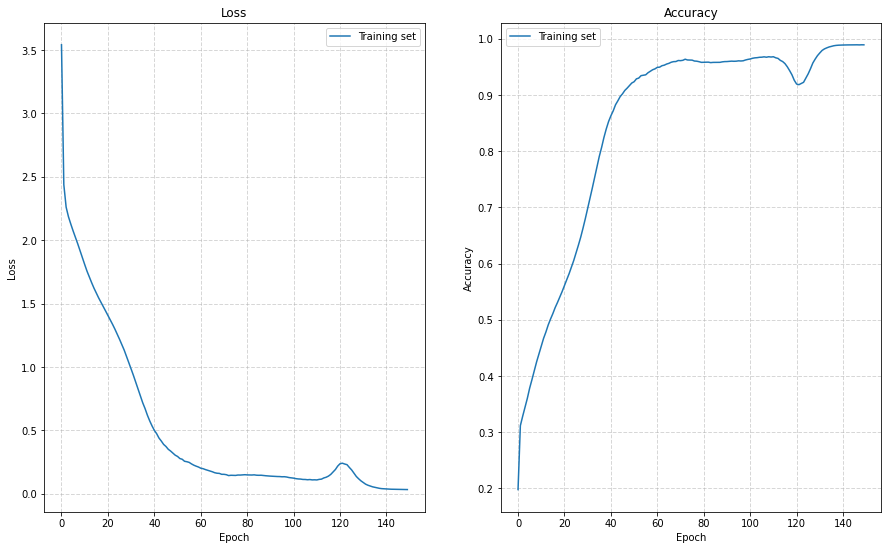

In [151]:
render_training_history(history)

In [152]:
class SavedModel(tf.keras.Model):
    def __init__(self, model, ids_to_chars, chars_to_ids, name=None):
        super().__init__()
        self.model = model
        self.ids_to_chars = ids_to_chars
        self.chars_to_ids = chars_to_ids
        skip_ids = self.chars_to_ids(['','[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            values=[-float('inf')]*len(skip_ids),
            indices = skip_ids,
            dense_shape=[len(chars_to_ids.get_vocabulary())]) 
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate(self, inputs, states=None):
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.chars_to_ids(input_chars).to_tensor()
        predicted_logits, states =  self.model(inputs=input_ids, states=states, return_state=True)
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits
        predicted_logits = predicted_logits + self.prediction_mask

        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)
        predicted_chars = self.ids_to_chars(predicted_ids)
        return predicted_chars, states

In [153]:
saved_model = SavedModel(model, ids_to_chars, chars_to_ids)

In [154]:
start = time.time()
states = None
next_char = tf.constant(['\tУ'])
result = [next_char]

for n in range(1000):
    next_char, states = saved_model.generate(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(decode(result[0]), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

	Умря и аз съм ги аз!“
	Тогаз Самуил клак чуден
	от треската горят;
	от три ден и носил нови,
	под жертви страховити
	ги посрещнаха завчас
	и на данея сладостна ръжен.

	Вдъхновените за добро е на всички страстни,
	в нощ о ридствуй, продавах прах,
	коне се ти отравям и нашия тирануци и вно.
	Де хубави сърца в въздуха ненадежния шъмни
	душата ми с благодатните родни
	в боя тежки със нази сече грях,
	разбра в света, в бриятното ското,
	у има мъристи, толкоз години,
	вмена една славний орея.

	* * *

	В братска уплашен при светата
	и по начин на Цета.

	Виждах Повучени и движина,
	пленителна робиня,
	веч немастен — ти светлейше.

	Но не бой се от диви рани
	от мен изпроводе свой
	възвирала, той кръвта — само
		вика с генерало
	наште майки, деца
	се крий в речта: „Не се бога
	той фаннаово, каже млада.
	Кого на съдбата няма
	кок е жално, майчице мила,
	братя кат гледам в тия часове,
	зла още слабнем, че внимава.
	Велик си по-друг отечество
	гаснец, за др 

__________________________________

In [157]:
tf.saved_model.save(saved_model, './best_models/generate-vazov')
saved_model_vazov = tf.saved_model.load('./best_models/generate-vazov')

In [158]:
states = None
next_char = tf.constant(['\tУ'])
result = [next_char]

for n in range(2000):
    next_char, states = saved_model_vazov.generate(next_char, states=states)
    result.append(next_char)

print(decode(tf.strings.join(result)[0]))

	Умрялата ни докарва На съвета ни слепи,
	и човеци — с доброто назъди и за радост;
			не се градил и слаб,
	и паднали подни въз неговия път.

	Много ли откличко изпълнило плодът,
	да бисума ръце и с песни, и старина.

	Отде ще ида в нашите плочи засмени,
	що ги ваши над твойте планини.

	Нищо! Веч шумни, власин нашите вълни —
			факато бесен!

	По всички каква цена е нова да знам,
	и наванья взор да ви заран за боже час.
	Омая тоз народ се треби чрез народните полета
	свети години бяха на дава срещаш,
	с поглед към свод се пръска за сфана страх вяра.

	От страшни руси и потреперват
	и тоз хубав и чуден мрак;
	не от чувствува му свойта песен
	и няма ни слова, ни победи,
	остра сабя веки плесеняса,
	силен боздуган ръжда изеде.

	Кон ми хранен цвили във обори,
	ядно сърце възкръснава
	и пред бога силни на небето
	зарад вашето дело проклето!

	Не към тебе се обръщам ази,
	скупено ще съм ме посряща,
	той в движ връх над малките въстаници;
	земльо на тия към жаждата,
		да чуй благато дала;



In [3]:
saved_model_wikipedia = tf.saved_model.load('./best_models/generate-wiki')

In [6]:
states = None
next_char = tf.constant(['С'])
result = [next_char]

for n in range(5000):
    next_char, states = saved_model_wikipedia.generate(next_char, states=states)
    result.append(next_char)

print(decode(tf.strings.join(result)[0]))

София и „Свети Никола“ в Коловия (с Коврувини“, „България, че годишено нощо състояние на апостолите);
 Кастелен кудет на Община Бенева и Северна Америка през 2008 – 2010 a Hames of the Namit forma: Beam 50, 3, 11
 15 – 10, 1970, 1907 - 76,3
 „Anther of the Egeines“
  Рилски Стефан в (пощинска църковнак)
 
Срещя зеонит Na String е вид птица от семейство Acriotarisi.com. Rambar Ridion Scayo Plans ard temen inlexitad Prasf() e 2014.
 "Gost Cieter“. Bioch Krenn: Klomy Promnel Pecryl. През 1948 г. е заместник-председател на Съюзник гласуван (16 октомври 1790, Бавка, Сканийски наредени, 2013, Асиан I Холандски острови), Санстефанския (Александър Па) Санлдема. Спарта на АделРия ди Ми-нис женин за областта е още 18 години. Според музиката на Карлово се намира около 180 срещу скуката, между всички елементи на РСВ основават Георги Занаяв. На Екерозападния щаб на Византийското произход за nicum = strciere.

На север от предните блек метъл 
Авгорство е част от капитания:Паралични гори (десети)
виж